<a href="https://colab.research.google.com/github/AbrahamAzizi/MPI-StochasticLangevinModel/blob/main/CoupledBrownNeelLangevin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import butter, filtfilt, savgol_filter
from scipy.signal.windows import hann, blackmanharris, kaiser
from scipy import signal

In [ ]:
Ht = lambda f, t: np.cos(2*np.pi*f*t)

# Knopp, Tobias, Nadine Gdaniec, and Martin Möddel. "Magnetic particle imaging:
# from proof of principle to preclinical applications.
# " Physics in Medicine & Biology 62, no. 14 (2017): R124.
def particleConcenteration(dcore, ironDensity):
  dcore = 30*1e-9
  Vc = (np.pi/6)*dcore**3
  print("core volume= ", Vc)
  ro = 5200 # kg/m3 for magnetite (Fe3O4)
  coreWeight = ro*Vc
  print("one magnetite particle weight= ", coreWeight)
  molMass = 0.232 # kg/mol molar mass of magnetite
  nAtomPerParticle = coreWeight/molMass # mol
  print("number of iron atoms inside one particle= ", nAtomPerParticle)
  cns = ironDensity/nAtomPerParticle # number of particles / lit
  print("concenteration of magnetite= ", "{:e}".format(cns))
  return cns

def low_pass_filter(signal, order, fs, fpass):
  fnyq = 0.5 * fs        # Nyquist frequency
  cutoff = fpass / fnyq  # Normalized cutoff frequency
  b, a = butter(order, cutoff, btype='low')
  return filtfilt(b, a,  signal)

# Neel relaxation time Fannin and Charless
def NeelRelaxation(sig, t0):
  if sig < 1:
    return t0 * (1 - 2 / 5 * sig + 48 / 875 * sig ** 2) ** (-1)
  else:
    return t0 * np.exp(sig) / 2 * np.sqrt(np.pi / sig ** 3)

class Data:
  def __init__(self, kB=1.381e-23, gamGyro=1.76e11, Ms=4.8e5, dCore=30e-9, dHyd=40e-9,
                 temp=300, alpha=1, kAnis=3e3, visc=1e-3, fieldAmpl=20e-3,
                 nPeriod=3, fieldFreq=25e3, rsol=20, nParticle=1000):

    self.kB = kB
    self.gamGyro = gamGyro
    self.Ms = Ms
    self.dCore = dCore
    self.dHyd = dHyd
    self.temp = temp
    self.alpha = alpha
    self.kAnis = kAnis
    self.visc = visc
    self.fieldAmpl = fieldAmpl
    self.nPeriod = nPeriod
    self.fieldFreq = fieldFreq
    self.rsol = rsol # number of samples per period -> for signal resolution
    self.nParticle = nParticle

In [ ]:
f = 25e3
B = 20e-3
Ms = 4.8e5
rsol = 100 # this value for each half of a period since it multiplied by 2*f where 2 counts Nyquist
num = 1000

data = Data()

cycs = 3
data.nPeriod = cycs
dco = 30e-9
Vc = 1 / 6 * np.pi * dco ** 3
mu = Ms * Vc
data.dCore = dco
data.dHyd = dco+10e-9

data.fieldFreq = f
print("list of applied field frequencies: ", data.fieldFreq)
data.fieldAmpl = B
print("list of applied field amplitudes: ", data.fieldAmpl)
data.rsol = rsol # 20 for 1 MHz
print("number of samples per period: ", 2*data.rsol)
data.nParticle = num
print("number of particles: ", data.nParticle)

fs = rsol*2*f
print("sampling frequency: f= ", f)
dt = 1/fs
print("time step: dt=", dt)
tf = cycs*(1/f)
print("final simulation time: tf=", tf)
lent = int(np.ceil(tf/dt))
print("length of simulation time: lent=", lent)

t = np.array([i*dt for i in range(lent)])
He = np.array([B*Ht(f,i*dt) for i in range(lent)])

# winlen is equal with rsol since after offset length we have min field ( cos wave )
# value at pi/4 and max field value at pi/2 where the saturation occures
winlen = (np.where(He == np.min(He))[0][0] - np.where(He == np.max(He))[0][0])
print("window length: winlen=", winlen)
wincnt = int(len(He)/winlen)
print("number of windowed segments: wincnt=", wincnt)
offlen = winlen//2
print("offset segment length: offlen=", offlen) # ignoring the first quantile of the first period due to unstabilization

list of applied field frequencies:  25000.0
list of applied field amplitudes:  0.02
number of samples per period:  200
number of particles:  1000
sampling frequency: f=  25000.0
time step: dt= 2e-07
final simulation time: tf= 0.00012000000000000002
length of simulation time: lent= 601
window length: winlen= 100
number of windowed segments: wincnt= 6
offset segment length: offlen= 50


In [ ]:
def CombinedNeelBrown(data):
    al = data.alpha
    gam = data.gamGyro
    visc = data.visc
    cycs = data.nPeriod
    num = data.nParticle
    kT = data.kB*data.temp
    B = data.fieldAmpl
    f = data.fieldFreq
    dco = data.dCore
    dhy = data.dHyd
    Ms = data.Ms
    ka = data.kAnis
    Vc = 1 / 6 * np.pi * dco ** 3
    Vh = 1 / 6 * np.pi * dhy ** 3
    mu = Ms * Vc
    sig = ka * Vc / kT
    t0 = mu / (2 * gam * kT) * (1 + al ** 2) / al
    print("Neel attempting time: ", t0)
    tB = 3 * visc * Vh / kT
    print("Brown relaxation time: ", tB)
    xi0 = mu * B / kT
    fs = data.rsol*2*f # this cares about Nyquist sampling frequency fs > 2*f -> fs = Nsf * f
    print("sampling frequency: ", fs)
    dt = 1/fs
    print("time step: ", dt)
    tf = cycs*(1/f)
    print("final simulatin time(ms): ", tf*1e3)
    lent = int(np.ceil(tf/dt))
    wrf = 1e-3 # this is used to reduce the Wiener noise
    print("total time length: ", lent)
    ut = wrf*dt/tB
    print("Weiner noise power in Brownian dynamics: ", ut)
    vt = wrf*dt/t0
    print("Weiner noise power in Magnetization dynamics: ", vt)
    nrf = .1 # this is the noise reduction factor
    np.random.seed(42)

    M = np.zeros((lent, 3))
    N = np.zeros((lent, 3))
    m = np.tile([1, 0, 0], (num, 1))
    n = m.copy()
    xI= np.tile([0, 0, xi0], (num, 1))

    for j in range(lent):

        M[j, :] = np.mean(m, axis=0)
        N[j, :] = np.mean(n, axis=0)

        a = np.sum(m * n, axis=1)
        dn = sig*a[:, np.newaxis] * (m - a[:, np.newaxis] * n) * ut + nrf*np.cross(np.random.randn(num, 3), n) * np.sqrt(ut)
        n = n + dn
        n = n / np.linalg.norm(n, axis=1, keepdims=True)
        # total field over time
        xi = xI * Ht(f,j*dt) + 2*sig * a[:, np.newaxis] * n

        h = np.random.randn(num, 3)
        f1 = np.cross(xi / al + np.cross(m, xi), m) / 2
        g1 = np.cross(h / al + np.cross(m, h), m)
        mb = m + f1 * vt + nrf*g1 * np.sqrt(vt)

        a = np.sum(mb * n, axis=1)

        xi = xI * Ht(f,(j+1)*dt) * 2*sig * a[:, np.newaxis] * n

        h = np.random.randn(num, 3)
        f2 = np.cross(xi / al + np.cross(mb, xi), mb) / 2
        g2 = np.cross(h / al + np.cross(mb, h), mb)

        m = m + (f1 + f2) * vt / 2 + (g1 + g2) * np.sqrt(vt) / 2
        m = m / np.linalg.norm(m, axis=1, keepdims=True)

        print('\r', 'time step in samples: ' + "." * 10 + " ", end=str(j)+'/'+str(lent-1))

    return M, N

In [ ]:
M, _ = CombinedNeelBrown(data)

Neel attempting time:  9.306278020639897e-09
Brown relaxation time:  2.426525824640922e-05
sampling frequency:  5000000.0
time step:  2e-07
final simulatin time(ms):  0.12000000000000002
total time length:  601
Weiner noise power in Brownian dynamics:  8.242236615371529e-06
Weiner noise power in Magnetization dynamics:  0.02149086880452429
 time step in samples: .......... 600/600

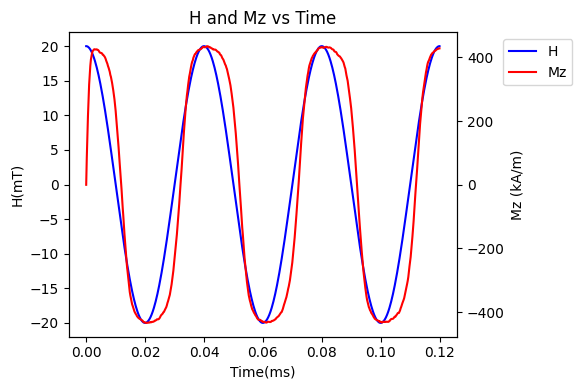

In [ ]:

Mz = Ms*M[:,2]
# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(t*1e3, He*1e3, '-b', label='H')
# ax1.plot(t[offlen:]*1e3, He[offlen:]*1e3, '-b', label='H') # remove async part
ax1.set_xlabel('Time(ms)')
ax1.set_ylabel('H(mT)')
ax2 = ax1.twinx()
ax2.plot(t*1e3, Mz*1e-3, '-r', label='Mz')
#ax2.plot(t[offlen:]*1e3, Mz[offlen:]*1e-3, '-r', label='Mz')
ax2.set_ylabel('Mz (kA/m)')

#ax1.set_xlim(t[t.shape[0]//5], t[t.shape[0]//2])

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1.1, 1))

plt.title('H and Mz vs Time')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'M(kA/m)')

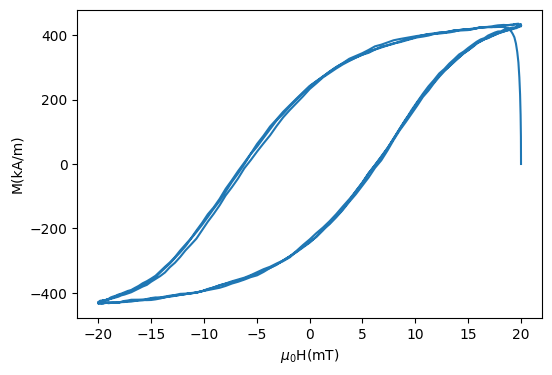

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(He*1e3, Mz*1e-3)
#plt.plot(He[offlen:]*1e3, Mz[offlen:]*1e-3) # removing async part
plt.xlabel('$\mu_0$H(mT)')
plt.ylabel('M(kA/m)')


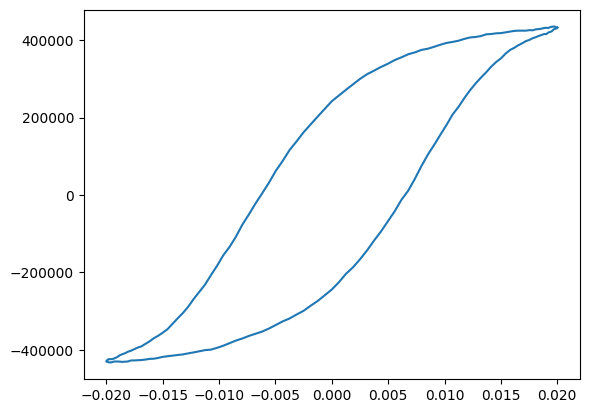

In [ ]:
plt.plot(He[2*winlen:4*winlen], Mz[2*winlen:4*winlen])

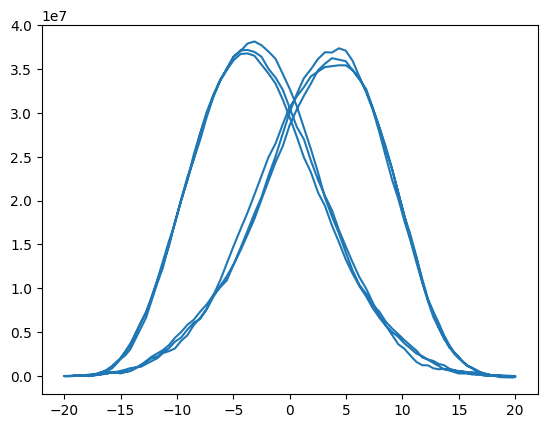

In [ ]:
dM = np.diff(Mz)
dH = np.diff(He)
dMdH = dM/dH # ignoring the first quarter of the first period becuse of stabilization
psf = np.zeros(len(dMdH))
for i in range(wincnt):
  tmp = dMdH[i*winlen : (i+1)*winlen]
  psf[i*winlen : (i+1)*winlen] = savgol_filter(kaiser(winlen, 14)*tmp, 20, 2, mode='nearest')

plt.plot(He[:-1]*1e3, psf)

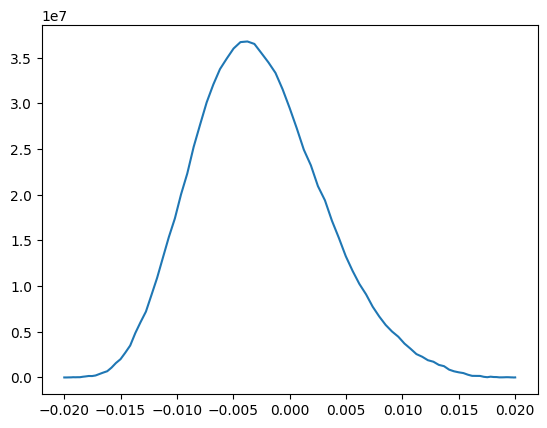

In [ ]:
plt.plot(He[2*winlen:3*winlen], psf[2*winlen:3*winlen])

In [ ]:
pz = 20e-3*795.7747/1.59 #A/m/A   1T = 795.7747 A/m, I = 1.59 A
u0 = 4*np.pi*1e-7 # T.m/A, v.s/A/m
print('coil sensitivity= ', pz)
sfactor = 625e-9

dift = np.diff(t)
dM = sfactor*np.diff(u0*Mz)
dMdt = dM/dift # ignoring the first quarter of the first period becuse of stabilization
uz = np.zeros(len(dMdt))
for i in range(wincnt):
  tmp = dMdt[i*winlen : (i+1)*winlen]
  uz[i*winlen : (i+1)*winlen] = savgol_filter(-pz*u0*kaiser(winlen,14)*tmp, 20, 2, mode='nearest')

coil sensitivity=  10.00974465408805


Text(0.5, 1.0, 'voltage in the direction of applied field')

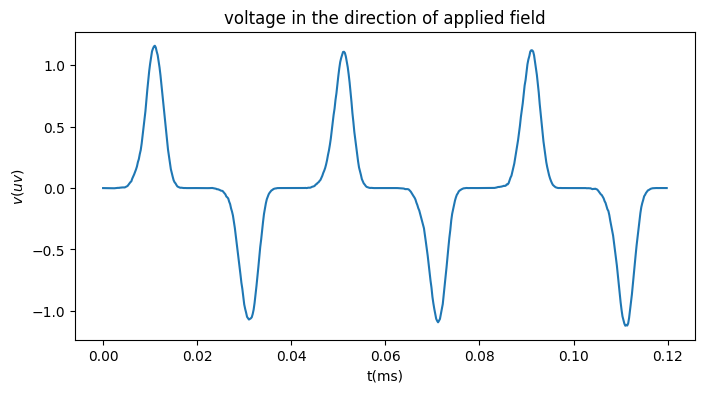

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(t[:-1]*1e3, uz*1e6)
plt.ylabel('$v(uv)$')
plt.xlabel('t(ms)')
plt.title('voltage in the direction of applied field')

Text(0.5, 0, 'Frequncy normalized in f')

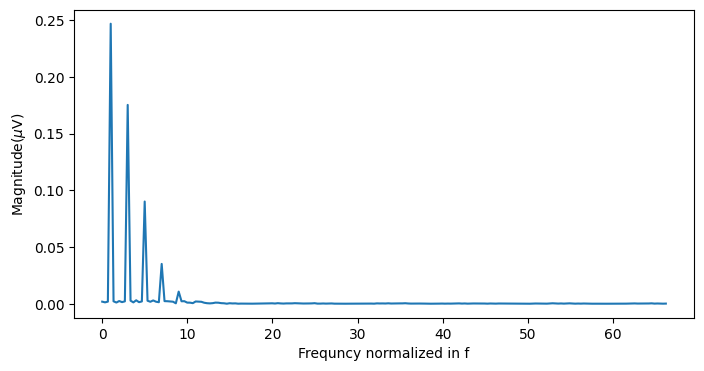

In [ ]:
freqs = np.fft.fftfreq(lent, dt)
N = len(freqs) // 2
x = np.fft.fftshift(freqs/f)[N:N+200]
uk = np.fft.fft(uz)
y = 1e6*abs(np.fft.fftshift(uk)/len(uk))[N:N+200]  # 1e6 for scaling to uv

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, y)
ax.set_ylabel('Magnitude($\mu$V)')
ax.set_xlabel('Frequncy normalized in f')